Need to add `Tensorboard` to my experiments.

In [1]:
import sys
import os 
import ast
import torch
import joblib
import numpy as np
import pandas as pd
from PIL import Image
import albumentations
from tqdm import tqdm
import torch.nn as nn
from pathlib import Path
from pdb import set_trace
from matplotlib import pyplot as plt
import torchvision.models as models
from torch.nn import functional as F
from sklearn.metrics import recall_score
import pretrainedmodels
import logging 
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

sys.path.append("../src")

In [2]:
from torch.utils.tensorboard import SummaryWriter

In [3]:
# writer = SummaryWriter()

In [4]:
torch.cuda.is_available()

True

In [5]:
!nvidia-smi

Sat Mar  7 00:30:46 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:1E.0 Off |                    0 |
| N/A   51C    P8    12W /  70W |     11MiB / 15109MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## DataSet

In [6]:
data_path = Path("../data")
df = pd.read_csv(data_path/'train_folds.csv')
df.head()

,image_id,grapheme_root,vowel_diacritic,consonant_diacritic,grapheme,kfold
0,Train_84143,99,1,0,প্না,1
1,Train_72913,148,2,0,স্কি,1
2,Train_46642,38,7,2,র্চে,3
3,Train_26255,68,0,0,ত্ন,2
4,Train_21993,83,0,0,ন্ট,2


In [7]:
class BengaliDataset():
    def __init__(self, folds, data_path="../data", height=137, width=236, random_state=123, subset=False, _df=None):
        data_path = Path(data_path)
        df = pd.read_csv(data_path/'train_folds.csv')
        
        if subset: df = _df
        
        df = df[['image_id', 'grapheme_root', 'vowel_diacritic', 'consonant_diacritic', 'kfold']]
        df = df[df.kfold.isin(folds)].reset_index(drop=True)
                
        self.df = df
        self.data_path=data_path
        self.img_ids = df['image_id'].values
        self.grapheme_root = df['grapheme_root'].values
        self.vowel_diacritic = df['vowel_diacritic'].values
        self.consonant_diacritic = df['consonant_diacritic'].values
        self.h = height
        self.w = width
        
        if len(folds) == 1: 
            self.aug = albumentations.Compose([
                albumentations.Resize(self.h, self.w, always_apply=True), 
                albumentations.Normalize(always_apply=True) #uses imagenette stats by default
            ])
        else:
            self.aug = albumentations.Compose([
                albumentations.Resize(self.h, self.w, always_apply=True),
                albumentations.Normalize(always_apply=True) #uses imagenette stats by default
            ])
            
    def __len__(self):
        return len(self.img_ids)
    
    def __getitem__(self, idx):
        image = joblib.load(f"{self.data_path}/image_pickles/{self.img_ids[idx]}.pkl")
        image = image.reshape(self.h, self.w).astype(float)
        image = Image.fromarray(image).convert("RGB")
        image = self.aug(image=np.array(image))['image']
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        return {
            'image': torch.tensor(image, dtype=torch.float),
            'grapheme_root': torch.tensor(self.grapheme_root[idx], dtype=torch.long), 
            'vowel_diacritic': torch.tensor(self.vowel_diacritic[idx], dtype=torch.long), 
            'consonant_diacritic': torch.tensor(self.consonant_diacritic[idx], dtype=torch.long), 
        }
    
    def show_image(self, idx, ax):
        image = joblib.load(f"{self.data_path}/image_pickles/{self.img_ids[idx]}.pkl")
        image = image.reshape(self.h, self.w).astype(float)
        image = Image.fromarray(image).convert("RGB")
        image = self.aug(image=np.array(image))['image']
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        ax.imshow(np.transpose(image, [1, 2, 0]))
        
    def show_batch(self, num_batch=3, seed=1):
        np.random.seed(seed)
        cols = num_batch // 3 if num_batch > 3 else num_batch
        fig, ax = plt.subplots(cols,3, figsize=(10,10))
        for j in range(cols):
            for i in range(3):
                idx   = np.random.choice(len(self.img_ids))
                self.show_image(idx, ax[j][i])

In [8]:
np.random.seed(1)
folds   = np.random.permutation(5)
trn_fld = folds[:4]
val_fld = folds[4:]
print(f"train folds: {trn_fld}, val fold: {val_fld}")

dataset = BengaliDataset(folds=trn_fld)
len(dataset)

train folds: [2 1 4 0], val fold: [3]


160672

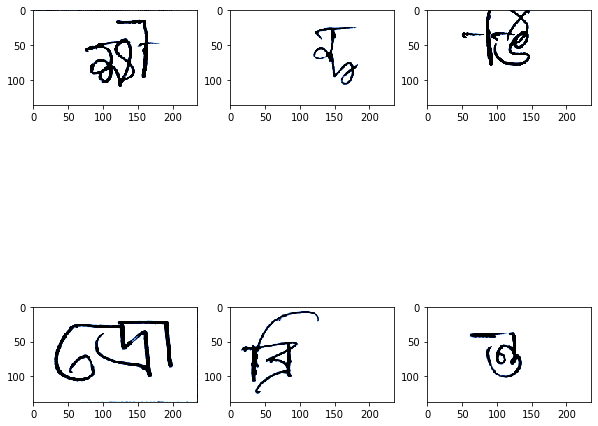

In [9]:
dataset.show_batch(num_batch=6);

## Model

In [10]:
class LinearHeadx1(nn.Module):
    def __init__(self, n_in, n_out, n_mid=None, bias=True):
        super(LinearHeadx1, self).__init__()
        if n_mid:
            self.li = nn.Linear(n_in, n_mid, bias=bias)
            self.relu = F.relu
        self.n_mid = n_mid
        self.lf = nn.Linear(n_in if not n_mid else n_mid, n_out, bias=bias) 

    def forward(self, x):
        return self.lf(x) if not self.n_mid else self.lf(F.relu(self.li(x)))

In [11]:
class LinearHeadx3(nn.Module):
    def __init__(self, n_in, n_mid=None):
        super(LinearHeadx3, self).__init__()
        self.l0 = LinearHeadx1(n_in, 168, n_mid)
        self.l1 = LinearHeadx1(n_in, 11, n_mid)
        self.l2 = LinearHeadx1(n_in, 7, n_mid)

    def forward(self, x):
        l0 = self.l0(x)  
        l1 = self.l1(x)
        l2 = self.l2(x)
        return l0, l1, l2

In [12]:
class Resnet34(nn.Module):
    "Create resnet 34 with custom_head; returns 3 outputs if nf=3 else 1 output; adds relu to custom_head if n_mid"
    def __init__(self, n_in, n_out=None, n_mid=None, nf=3, pretrained=False):
        super(Resnet34, self).__init__()
        model = models.resnet34(pretrained)
        features = nn.Sequential(
            *list(model.children())[:-2]
            )
        # group in initial, middle and later for discriminative learning rate
        self.initial_layers = features[:4]
        self.middle_layers  = features[4:7]
        self.later_layers   = features[7:]
        self.custom_head    = LinearHeadx3(n_in, n_mid) if nf==3 else LinearHeadx1(n_in, n_out, n_mid)
        
    def forward(self, x):
        bs, _, _, _ = x.shape
        x  = self.initial_layers(x)
        x  = self.middle_layers(x)
        x  = self.later_layers(x)
        x  = F.adaptive_avg_pool2d(x, 1).reshape(bs, -1)
        return self.custom_head(x)

In [13]:
class SE_Resnext50(nn.Module):
    def __init__(self, n_in, n_out=None, n_mid=None, pretrained=True, nf=3):
        super(SE_Resnext50, self).__init__()
        model  = pretrainedmodels.__dict__['se_resnext50_32x4d'](num_classes=1000, pretrained='imagenet' if pretrained else None)     
        features = nn.Sequential(
            *list(model.children())[:-2]
            )
        self.initial_layers = features[:2]
        self.middle_layers  = features[2]
        self.later_layers   = features[3:]
        self.custom_head    = LinearHeadx3(n_in, n_mid) if nf==3 else LinearHeadx1(n_in, n_out, n_mid)
        
    def forward(self, x):
        bs, _, _, _ = x.shape
        x  = self.initial_layers(x)
        x  = self.middle_layers(x)
        x  = self.later_layers(x)
        x  = F.adaptive_avg_pool2d(x, 1).reshape(bs, -1)
        return self.custom_head(x)        

In [14]:
class EfficientNetB4(nn.Module):
    "Create resnet 34 with custom_head; returns 3 outputs if nf=3 else 1 output; adds relu to custom_head if n_mid"
    def __init__(self, n_in, n_out=None, n_mid=None, nf=3, pretrained=False):
        super(EfficientNetB4, self).__init__()
        model = EfficientNet.from_pretrained('efficientnet-b4')
        features = nn.Sequential(
        
            *list(model.children())[:-2]
            )
        # group in initial, middle and later for discriminative learning rate
        
        self.initial_layers = features[:2]
        self.middle_layers  = features[2:6]
        self.later_layers   = features[6:]
        self.custom_head    = LinearHeadx3(n_in, n_mid) if nf==3 else LinearHeadx1(n_in, n_out, n_mid)
        
    def forward(self, x):
        bs, _, _, _ = x.shape
        x  = self.initial_layers(x)
        x  = self.middle_layers(x)
        x  = self.later_layers(x)
        return self.custom_head(x)

In [15]:
MODEL_DISPATCHER = {
    'resnet34': Resnet34, 
    'se_resnext50': SE_Resnext50, 
    'efficientnetb4': EfficientNetB4
}

## Train & Validate

Initializing model with pretrained weights : Resnet101

In [16]:
def ifnone(a, b):
    return a if b is None else b

In [17]:
def get_ds_dl(Dataset, trn_fld=trn_fld, val_fld=val_fld, train_dataset=None, 
              train_dataloader=None, valid_dataset=None, valid_dataloader=None, 
              bs=256, subset=True, _df=None):
    logger.info(f"Train folds: {trn_fld}, validation fold: {val_fld}")
    train_dataset = ifnone(Dataset(folds=trn_fld, subset=subset, _df=df), train_dataset)
    train_dataloader = ifnone(torch.utils.data.DataLoader(train_dataset, batch_size=bs, shuffle=False, 
                                                   num_workers=4), train_dataloader)
    
    valid_dataset = ifnone(Dataset(folds=[val_fld], subset=subset, _df=df), valid_dataset)
    valid_dataloader = ifnone(torch.utils.data.DataLoader(valid_dataset, batch_size=bs, shuffle=True, num_workers=4), 
                              valid_dataloader)
    return train_dataset, train_dataloader, valid_dataset, valid_dataloader

In [18]:
def loss_func_x1(outputs, targets):
    return nn.CrossEntropyLoss()(outputs, targets)

In [19]:
def loss_func_x3(outputs, targets, weighted=True):
    "return weighted loss if needed"
    grapheme_root, vowel_diacritic, consonant_diacritic = outputs
    grapheme_root_, vowel_diacritic_, consonant_diacritic_ = targets 
    l1 = loss_func_x1(grapheme_root, grapheme_root_)
    l2 = loss_func_x1(vowel_diacritic, vowel_diacritic_)
    l3 = loss_func_x1(consonant_diacritic, consonant_diacritic_)
    return ((2*l1)+l2+l3)/3  if weighted else (l1+l2+l3)/3

In [20]:
def recall_score_x1(outputs, targets):
    outputs = outputs.detach().cpu().numpy().argmax(axis=1)
    targets = targets.detach().cpu().numpy()
    return np.round(recall_score(targets, outputs, average='macro'), 4)*100

In [21]:
def recall_loss_x3(outputs, targets, ret_scores=True):
    "calculates weighted kaggle metric during validation"
    grapheme_root, vowel_diacritic, consonant_diacritic = outputs
    grapheme_root_, vowel_diacritic_, consonant_diacritic_ = targets 
    s1 = recall_score_x1(grapheme_root, grapheme_root_)
    s2 = recall_score_x1(vowel_diacritic, vowel_diacritic_)
    s3 = recall_score_x1(consonant_diacritic, consonant_diacritic_)
    scores = [s1, s2, s3]
    weighted_score = np.average(scores, weights=[2,1,1])
    return weighted_score, s1, s2, s3 if ret_scores else weighted_score

In [22]:
def trainx1(dataset, data_loader, model, optimizer, scheduler, component, DEVICE='cuda'):
    assert type(model.custom_head) == LinearHeadx1, "make sure model returns only one output"
    model.train()
    final_loss = 0
    counter = 0
    for bi, d in tqdm(enumerate(data_loader), total=int(len(dataset) / data_loader.batch_size)):
        image = d['image']
        y     = d[component]
        image = image.to(DEVICE, dtype=torch.float)
        y = y.to(DEVICE, dtype=torch.long)
        optimizer.zero_grad()
        outputs = model(image)
        targets = y
        loss = loss_func_x1(outputs, targets)
        loss.backward()
        optimizer.step()
        scheduler.step()
        final_loss += float(loss)
        counter += 1
    return final_loss/counter

In [23]:
def trainx3(dataset, data_loader, model, optimizer, scheduler, DEVICE='cuda'):
    assert type(model.custom_head) == LinearHeadx3, "make sure model returns three outputs"
    model.train()
    final_loss = 0
    counter = 0
    for bi, d in tqdm(enumerate(data_loader), total=int(len(dataset) / data_loader.batch_size)):
        image = d['image']
        grapheme_root = d['grapheme_root']
        vowel_diacritic = d['vowel_diacritic']
        consonant_diacritic = d['consonant_diacritic']

        image = image.to(DEVICE, dtype=torch.float)
        grapheme_root = grapheme_root.to(DEVICE, dtype=torch.long)
        vowel_diacritic = vowel_diacritic.to(DEVICE, dtype=torch.long)
        consonant_diacritic = consonant_diacritic.to(DEVICE, dtype=torch.long)

        optimizer.zero_grad()
        outputs = model(image)
        targets = (grapheme_root, vowel_diacritic, consonant_diacritic)
        loss = loss_func_x3(outputs, targets)
        loss.backward()
        optimizer.step()
        scheduler.step()
        final_loss += float(loss)
        counter += 1
    return final_loss/counter

In [24]:
def evaluatex1(dataset, data_loader, model, component, DEVICE='cuda'):
    model.eval()
    final_loss, final_score, final_l1, final_l2, final_l3, counter = 0, 0, 0, 0, 0, 0
    for bi, d in tqdm(enumerate(data_loader), total=int(len(dataset) / data_loader.batch_size)):
        counter+=1
        image = d['image']
        y = d[component]

        image = image.to(DEVICE, dtype=torch.float)
        y = y.to(DEVICE, dtype=torch.long)

        with torch.no_grad():
            outputs = model(image)
            targets = y 
            loss = loss_func_x1(outputs, targets)
            final_loss += float(loss)
            score = recall_score_x1(outputs, targets)
            final_score += score
    return np.round(final_loss/counter,2), np.round(final_score/counter,2)

In [25]:
def evaluatex3(dataset, data_loader, model, DEVICE='cuda'):
    model.eval()
    final_loss, final_score, final_l1, final_l2, final_l3, counter = 0, 0, 0, 0, 0, 0
    for bi, d in tqdm(enumerate(data_loader), total=int(len(dataset) / data_loader.batch_size)):
        counter+=1
        image = d['image']
        grapheme_root = d['grapheme_root']
        vowel_diacritic = d['vowel_diacritic']
        consonant_diacritic = d['consonant_diacritic']

        image = image.to(DEVICE, dtype=torch.float)
        grapheme_root = grapheme_root.to(DEVICE, dtype=torch.long)
        vowel_diacritic = vowel_diacritic.to(DEVICE, dtype=torch.long)
        consonant_diacritic = consonant_diacritic.to(DEVICE, dtype=torch.long)

        with torch.no_grad():
            outputs = model(image)
            targets = (grapheme_root, vowel_diacritic, consonant_diacritic)
            loss = loss_func_x3(outputs, targets)
            final_loss += float(loss)
            score, l1, l2, l3 = recall_loss_x3(outputs, targets)
            final_score += score
            final_l1 += l1
            final_l2 += l2
            final_l3 += l2
    return np.round(final_loss/counter,2), np.round(final_score/counter,2), np.round(final_l1/counter,2), np.round(final_l2/counter,2), np.round(final_l3/counter,2)

## Re-init model

In [26]:
def get_model(model="resnet34", cuda=True, **model_kwargs):
    model = MODEL_DISPATCHER[model](pretrained=True, **model_kwargs)
    if cuda: model = model.to("cuda")
    return model

In [27]:
def reinit(model, bs=256, epochs=5, Dataset=BengaliDataset, trn_fld=trn_fld, val_fld=val_fld, 
           learning_rate=1e-3, train_dataset=None, train_dataloader=None, valid_dataset=None, 
           valid_dataloader=None, subset=True, _df=None, **model_kwargs
          ):
    if model_kwargs: logger.info(f"model_kwargs: {model_kwargs}")  
    model = get_model(model, **model_kwargs)
    train_dataset, train_dataloader, valid_dataset, valid_dataloader = get_ds_dl(Dataset, trn_fld, val_fld, train_dataset, train_dataloader, valid_dataset, valid_dataloader, bs, subset, _df=df)
    
    optimizer = torch.optim.Adam([  
        {'params': model.initial_layers.parameters(), 'lr': learning_rate/100},  
        {'params': model.middle_layers.parameters(), 'lr': learning_rate/10},  
        {'params': model.later_layers.parameters(), 'lr': learning_rate},  
        {'params': model.custom_head.parameters(), 'lr': learning_rate},  
    ], lr=learning_rate)
    
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer, 
        steps_per_epoch=int(len(train_dataset)/train_dataloader.batch_size),
        max_lr=learning_rate, 
        epochs=epochs
    )
    return model, train_dataset, train_dataloader, valid_dataset, valid_dataloader, optimizer, scheduler

## Fit Function

In [28]:
def fitx3(model, train_dataset, train_dataloader, valid_dataset, valid_dataloader, optimizer, scheduler, epochs = 10, DEVICE='cuda'):
    for epoch in range(epochs):
        logger.info(f"running epoch {epoch+1} of {epochs}..")
        trn_loss = trainx3(train_dataset, train_dataloader, model, optimizer, scheduler)
        val_loss, val_score, l1, l2, l3 = evaluatex3(valid_dataset, valid_dataloader, model)
        logger.info(f"validation recall score: {val_score}, grapheme_root recall: {l1}, vowel_diacritic recall: {l2}, consonant_diacritic recall: {l3}")

In [29]:
def fitx1(model, train_dataset, train_dataloader, valid_dataset, valid_dataloader, optimizer, scheduler, component, epochs = 10, DEVICE='cuda'):
    for epoch in range(epochs):
        logger.info(f"running epoch {epoch+1} of {epochs}..")
        trn_loss = trainx1(train_dataset, train_dataloader, model, optimizer, scheduler, component)
        val_loss, val_score = evaluatex1(valid_dataset, valid_dataloader, model, component)
        logger.info(f"validation recall score: {val_score}")

## Base model

In [30]:
df = df[df.grapheme_root.isin(list(df.grapheme_root.value_counts()[-15:])+[72])].reset_index(drop=True)
df.shape

(23030, 6)

In [ ]:
epochs=20
model, train_dataset, train_dataloader, valid_dataset, valid_dataloader, optimizer, scheduler = reinit(
    'resnet34', bs=256, epochs=epochs, Dataset=BengaliDataset, nf=1, n_in=512, n_out=168, subset=True, _df=df)
fitx1(model, train_dataset, train_dataloader, valid_dataset, valid_dataloader, optimizer, scheduler, "grapheme_root",
      epochs)

INFO:__main__:model_kwargs: {'nf': 1, 'n_in': 512, 'n_out': 168}
INFO:__main__:Train folds: [2 1 4 0], validation fold: [3]
INFO:__main__:running epoch 1 of 20..
  0%|          | 3/627 [00:03<13:58,  1.34s/it]

## Add Augmentation

## Add sampler

In [36]:
def reinit_(model, update_folds=False, bs=256, epochs=5):
    model = MODEL_DISPATCHER[model](pretrained=True)
    model = model.to("cuda")
    logger.info(f"Train folds: {trn_fld}, validation fold: {val_fld}")
    train_dataset = BengaliDataset(folds=trn_fld)
    
    weight_dict = dict(1/((train_dataset.df.grapheme_root.value_counts()/len(train_dataset.df))))
    samples_weight = np.array([weight_dict[t] for t in train_dataset.grapheme_root])
    
    sampler = torch.utils.data.sampler.WeightedRandomSampler(samples_weight, len(samples_weight), 
                                                             replacement=False)
    
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=bs, shuffle=False, 
                                                   sampler=sampler,
                                                   num_workers=4)
    valid_dataset = BengaliDataset(folds=[val_fld])
    valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=bs, shuffle=True, num_workers=4)
    optimizer = torch.optim.Adam([  
    {'params': model.initial_layers.parameters(), 'lr': learning_rate/100},  
    {'params': model.middle_layers.parameters(), 'lr': learning_rate/10},  
    {'params': model.later_layers.parameters(), 'lr': learning_rate},  
    {'params': model.linear_layers.parameters(), 'lr': learning_rate},  
], lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, 
    steps_per_epoch=int(len(train_dataset)/train_dataloader.batch_size),
    max_lr=learning_rate, 
    epochs=epochs
    )
    return model, train_dataset, train_dataloader, valid_dataset, valid_dataloader, optimizer, scheduler

In [37]:
model, train_dataset, train_dataloader, valid_dataset, valid_dataloader, optimizer, scheduler = reinit_('resnet101', epochs=15)

INFO:__main__:Train folds: [2 1 4 0], validation fold: [3]
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [38]:
EPOCHS = 15; DEVICE='cuda'
for epoch in range(EPOCHS):
    logger.info(f"running epoch {epoch+1} of {EPOCHS}..")
    trn_loss = train(train_dataset, train_dataloader, model, optimizer, scheduler)
    val_loss, val_score = evaluate(valid_dataset, valid_dataloader, model)
    logger.info(f"validation recall score: {val_score}")
    writer.add_scalars(
        'sampler_full', {'Loss/train': trn_loss, 'Loss/test': val_loss, 'val_score': val_score}, epoch
    )

INFO:__main__:running epoch 1 of 15..
628it [03:31,  2.96it/s]                         
  0%|          | 0/156 [00:00<?, ?it/s]/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
157it [00:23,  6.59it/s]                         
INFO:__main__:validation recall score: 0.6463248687093757
INFO:__main__:running epoch 2 of 15..
628it [03:31,  2.97it/s]                         
157it [00:23,  6.67it/s]                         
INFO:__main__:validation recall score: 0.681054678480499
INFO:__main__:running epoch 3 of 15..
628it [03:31,  2.97it/s]                         
157it [00:24,  6.52it/s]                         
INFO:__main__:validation recall score: 0.7094706006206782
INFO:__main__:running epoch 4 of 15..
628it [03:31,  2.97it/s]                         
157it [00:23,  6.71it/s]                         
INFO:__

## Add `HorizontalFlip`

In [52]:
train_dataset.aug =  albumentations.Compose([
                albumentations.Resize(train_dataset.h, train_dataset.w, always_apply=True),
                albumentations.HorizontalFlip(p=0.6),
                albumentations.Normalize(always_apply=True) 
            ])

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=256, 
    shuffle=True,
    num_workers=4
    )

In [53]:
model, train_dataset, train_dataloader, valid_dataset, valid_dataloader, optimizer, scheduler = reinit(
    'resnet34', bs=256, epochs=epochs, Dataset=BengaliDataset, nf=3, n_in=512, train_dataset=train_dataset, train_dataloader=train_dataloader)
# fitx3(model, train_dataset, train_dataloader, valid_dataset, valid_dataloader, optimizer, scheduler, epochs)

INFO:__main__:model_kwargs: {'nf': 3, 'n_in': 512}
INFO:__main__:Train folds: [2 1 4 0], validation fold: [3]


## Try `SeResNext50`

In [55]:
train_dataset.aug =  albumentations.Compose([
                albumentations.Resize(train_dataset.h, train_dataset.w, always_apply=True),
                albumentations.HorizontalFlip(p=0.6),
                albumentations.Normalize(always_apply=True) 
            ])

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=64, 
    shuffle=True,
    num_workers=4
    )

In [69]:
epochs = 20
model, train_dataset, train_dataloader, valid_dataset, valid_dataloader, optimizer, scheduler = reinit(
    'se_resnext50', bs=64, epochs=epochs, Dataset=BengaliDataset, nf=3, n_in=2048, n_mid=512, train_dataset=train_dataset, train_dataloader=train_dataloader)

INFO:__main__:model_kwargs: {'nf': 3, 'n_in': 2048, 'n_mid': 512}
INFO:__main__:Train folds: [2 1 4 0], validation fold: [3]


In [ ]:
fitx3(model, train_dataset, train_dataloader, valid_dataset, valid_dataloader, optimizer, scheduler, epochs)

INFO:__main__:running epoch 1 of 20..
 13%|█▎        | 36/287 [00:08<00:59,  4.20it/s]

## `Horizontal Flip` + `Grapheme Root` + `SeResnext50`

In [31]:
class GraphemeRootDataset(BengaliDataset):
    def __getitem__(self, idx):
        image = joblib.load(f"{self.data_path}/image_pickles/{self.img_ids[idx]}.pkl")
        image = image.reshape(self.h, self.w).astype(float)
        image = Image.fromarray(image).convert("RGB")
        image = self.aug(image=np.array(image))['image']
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        return {
            'image': torch.tensor(image, dtype=torch.float),
            'grapheme_root': torch.tensor(self.grapheme_root[idx], dtype=torch.long), 
        }

In [32]:
epochs=20
model, train_dataset, train_dataloader, valid_dataset, valid_dataloader, optimizer, scheduler = reinit(
    'se_resnext50', bs=64, epochs=epochs, Dataset=GraphemeRootDataset, nf=1, n_in=2048, n_out=168, n_mid=512, 
    subset=True)

INFO:__main__:model_kwargs: {'nf': 1, 'n_in': 2048, 'n_out': 168, 'n_mid': 512}
INFO:__main__:Train folds: [2 1 4 0], validation fold: [3]


In [33]:
model.custom_head

LinearHeadx1(
  (li): Linear(in_features=2048, out_features=512, bias=True)
  (lf): Linear(in_features=512, out_features=168, bias=True)
)

In [33]:
train_dataset.aug =  albumentations.Compose([
                albumentations.Resize(train_dataset.h, train_dataset.w, always_apply=True),
                albumentations.HorizontalFlip(p=0.6),
                albumentations.Cutout(16),
                albumentations.Normalize(always_apply=True) 
            ])

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=64, 
    shuffle=True,
    num_workers=4
    )

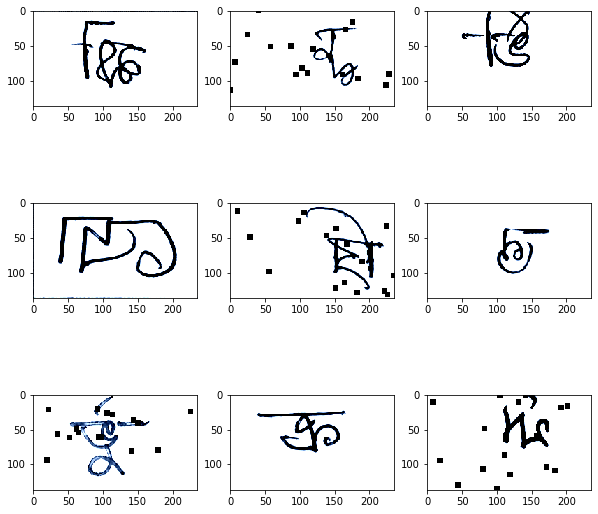

In [34]:
train_dataset.show_batch()

In [ ]:
fitx1(model, train_dataset, train_dataloader, valid_dataset, valid_dataloader, 
      optimizer=optimizer, scheduler=scheduler, epochs=epochs, component='grapheme_root')

INFO:__main__:running epoch 1 of 20..
288it [03:35,  1.34it/s]                         
  0%|          | 0/627 [00:00<?, ?it/s]/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
 48%|████▊     | 303/627 [01:09<01:14,  4.37it/s]

In [40]:
torch.save(model.state_dict(), "seresnext50_cutout-HRFlip_20epochs.bin")
torch.save(optimizer.state_dict(), 'opt.bin')

In [41]:
learning_rate = 1e-8
optimizer = torch.optim.Adam([  
    {'params': model.initial_layers.parameters(), 'lr': learning_rate/100},  
    {'params': model.middle_layers.parameters(), 'lr': learning_rate/10},  
    {'params': model.later_layers.parameters(), 'lr': learning_rate},  
    {'params': model.custom_head.parameters(), 'lr': learning_rate},  
], lr=learning_rate)

scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, 
    steps_per_epoch=int(len(train_dataset)/train_dataloader.batch_size),
    max_lr=learning_rate, 
    epochs=epochs
)

In [42]:
fitx1(model, train_dataset, train_dataloader, valid_dataset, valid_dataloader, 
      optimizer=optimizer, scheduler=scheduler, epochs=epochs, component='grapheme_root')

INFO:__main__:running epoch 1 of 20..
2511it [28:58,  1.44it/s]                          
  0%|          | 1/627 [00:00<03:13,  3.24it/s]/home/ubuntu/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
628it [02:07,  4.93it/s]                         
INFO:__main__:validation recall score: 90.3
INFO:__main__:running epoch 2 of 20..
 68%|██████▊   | 1697/2510 [19:34<09:24,  1.44it/s]

KeyboardInterrupt: 